# Question Detection from Speech Analysis

This notebook contains the data analysis process for detecting questions from speech using two approaches:
1. Intonation analysis through spectrograms
2. Syntactic analysis after speech-to-text conversion

## 1. Data Loading and Initial Exploration

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from collections import Counter

np.random.seed(42)
torch.manual_seed(42)

plt.style.use("seaborn-v0_8")
sns.set_theme()

### 1.1 Dataset Structure Analysis

In [5]:
def print_pair_stats(category, pairs, missing):
    """Helper function to print statistics for a category of files."""
    print(f"\n{category}:")
    print(f"  - Complete pairs: {len(pairs)}")
    print(f"  - Missing text files: {len(missing)}")
    if missing:
        print("  - Files missing text:")
        for file in missing[:5]:
            print(f"    * {file.name}")
        if len(missing) > 5:
            print(f"    * ... and {len(missing) - 5} more")


def find_matching_pairs(wav_files):
    """Helper function to find matching pairs of wav and txt files."""
    pairs = []
    missing = []
    for wav_file in wav_files:
        txt_file = wav_file.with_suffix(".txt")
        if txt_file.exists():
            pairs.append((wav_file, txt_file))
        else:
            missing.append(wav_file)
    return pairs, missing


def analyze_dataset_structure(base_path="dataset"):
    """Analyze the structure of the dataset and print statistics."""
    # Get paths
    questions_path = Path(base_path) / "questions"
    others_path = Path(base_path) / "others"

    # Get all wav files
    question_files = list(questions_path.glob("*.wav"))
    other_files = list(others_path.glob("*.wav"))

    # Print total counts
    print(f"Total number of audio files: {len(question_files) + len(other_files)}")
    print(f"Number of question files: {len(question_files)}")
    print(f"Number of non-question files: {len(other_files)}")

    # Find matching pairs
    question_pairs, question_missing = find_matching_pairs(question_files)
    other_pairs, other_missing = find_matching_pairs(other_files)

    # Print detailed statistics
    print("\nMatching pairs analysis:")
    print_pair_stats("Questions", question_pairs, question_missing)
    print_pair_stats("Non-questions", other_pairs, other_missing)

    return question_pairs, other_pairs

question_pairs, other_pairs = analyze_dataset_structure()

Total number of audio files: 15289
Number of question files: 5184
Number of non-question files: 10105

Matching pairs analysis:

Questions:
  - Complete pairs: 5184
  - Missing text files: 0

Non-questions:
  - Complete pairs: 10105
  - Missing text files: 0


In [6]:
def analyze_audio_files(pairs, label):
    """Analyze audio files and return statistics."""
    durations = []
    sample_rates = []

    for wav_file, _ in pairs:
        y, sr = librosa.load(wav_file)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
        sample_rates.append(sr)

    # Calculate statistics
    mean_duration = np.mean(durations)
    std_duration = np.std(durations)

    print(f"\nStatistics for {label}:")
    print("Duration statistics (seconds):")
    print(f"Average: {mean_duration:.2f}")
    print(f"Standard deviation: {std_duration:.2f}")
    print(f"Min: {np.min(durations):.2f}")
    print(f"Max: {np.max(durations):.2f}")
    print(f"Sample rate: {sample_rates[0]} Hz (all files have same rate)")

    # Calculate percentiles for better understanding of duration distribution
    percentiles = [25, 50, 75, 90, 95, 99]
    print("\nDuration percentiles (seconds):")
    for p in percentiles:
        print(f"{p}th percentile: {np.percentile(durations, p):.2f}")

    return durations, sample_rates


# Run analysis for both question and non-question files
question_durations, question_srs = analyze_audio_files(question_pairs, "Questions")
other_durations, other_srs = analyze_audio_files(other_pairs, "Non-questions")


Statistics for Questions:
Duration statistics (seconds):
Average: 5.98
Standard deviation: 6.54
Min: 0.00
Max: 175.13
Sample rate: 22050 Hz (all files have same rate)

Duration percentiles (seconds):
25th percentile: 2.83
50th percentile: 4.41
75th percentile: 6.98
90th percentile: 11.08
95th percentile: 14.87
99th percentile: 27.51

Statistics for Non-questions:
Duration statistics (seconds):
Average: 5.82
Standard deviation: 5.85
Min: 0.38
Max: 82.73
Sample rate: 22050 Hz (all files have same rate)

Duration percentiles (seconds):
25th percentile: 2.94
50th percentile: 4.49
75th percentile: 6.73
90th percentile: 9.83
95th percentile: 12.83
99th percentile: 34.07


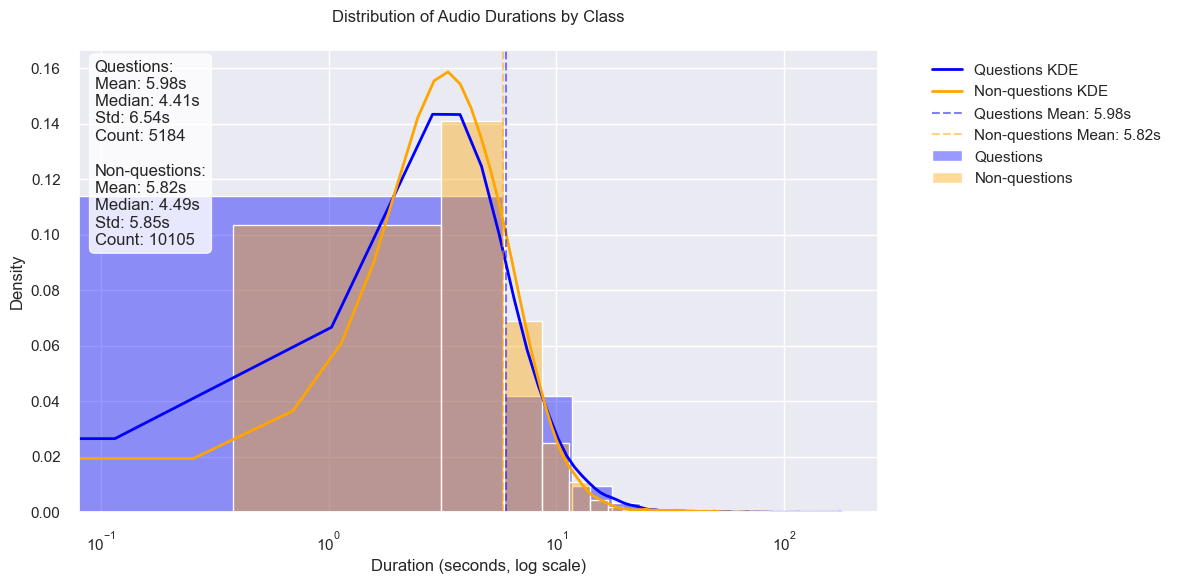

In [7]:
# Plot duration distributions with improved visualization
plt.figure(figsize=(12, 6))

# Create histograms with KDE
sns.histplot(
    data=question_durations,
    label="Questions",
    alpha=0.4,
    bins=30,
    stat="density",
    color="blue",
)
sns.histplot(
    data=other_durations,
    label="Non-questions",
    alpha=0.4,
    bins=30,
    stat="density",
    color="orange",
)

# Add KDE curves
sns.kdeplot(data=question_durations, label="Questions KDE", color="blue", linewidth=2)
sns.kdeplot(
    data=other_durations, label="Non-questions KDE", color="orange", linewidth=2
)

# Add vertical lines for means
plt.axvline(
    np.mean(question_durations),
    color="blue",
    linestyle="--",
    alpha=0.5,
    label=f"Questions Mean: {np.mean(question_durations):.2f}s",
)
plt.axvline(
    np.mean(other_durations),
    color="orange",
    linestyle="--",
    alpha=0.5,
    label=f"Non-questions Mean: {np.mean(other_durations):.2f}s",
)

# Set log scale for x-axis
plt.xscale("log")
plt.xlabel("Duration (seconds, log scale)")
plt.ylabel("Density")
plt.title("Distribution of Audio Durations by Class", pad=20)

# Add statistics text
stats_text = (
    f"Questions:\n"
    f"Mean: {np.mean(question_durations):.2f}s\n"
    f"Median: {np.median(question_durations):.2f}s\n"
    f"Std: {np.std(question_durations):.2f}s\n"
    f"Count: {len(question_durations)}\n\n"
    f"Non-questions:\n"
    f"Mean: {np.mean(other_durations):.2f}s\n"
    f"Median: {np.median(other_durations):.2f}s\n"
    f"Std: {np.std(other_durations):.2f}s\n"
    f"Count: {len(other_durations)}"
)
plt.text(
    0.02,
    0.98,
    stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()